In [ ]:
#!pip -q install speechrecognition

     |████████████████████████████████| 32.8 MB 1.7 MB/s 


In [ ]:
#!pip -q install gtts

In [ ]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
#from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
#import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [ ]:
# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
# Importing the dataset
with open('/content/intents.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
# Cetak data keseluruhan
data 

,patterns,tags
0,google,google
1,search,google
2,internet,google
3,OK google,google
4,What the time,datetime
...,...,...
668,beri saya pantun,pantun
669,bisakah kamu membuat pantun,pantun
670,pantun dong,pantun
671,kasih pantun dong,pantun


# **Preprocessing The Data**

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

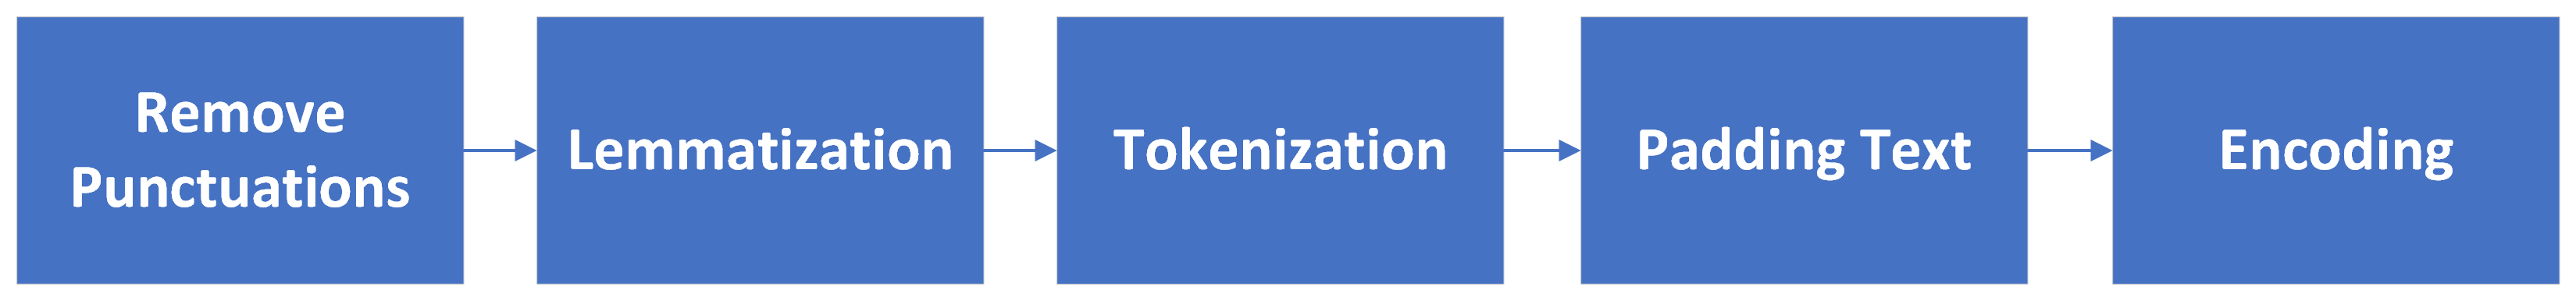

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

Kelima tahapan pemrosesan teks ini dijelaskan pada bagian langkah selanjutnya.

## **Remove Punctuations**

Tahapan praproses pada data teks yang pertama adalah menghapus punktuasi atau tanda baca seperti *special character* yaitu **'!'** (**tanda seru**) **','** (**tanda koma**) **'.'** (**tanda titik sebagai berhenti**) '**?**' (**tanda tanya**) dan tanda baca yang lain. Tahapan ini gunanya untuk mempermudah pemrosesan data teks yang akan kita olah.

In [ ]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## **Lemmatization (Lematisasi)**

Setelah menghapus punktuasi atau tanda baca, tahapan selanjutnya yaitu Lematisasi atau Lemmatization. **Apa itu Lematisasi?**

Lematisasi atau Lemmatization adalah proses dimana merujuk pada melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai ***lemma***. 

Contoh Lematisasi : **Menggunakan** (Kata Imbuhan) -> **Guna** (Kata Dasar) 

Dalam contoh berikut proses lematisasi awalnya data teks menggunakan kata imbuhan yaitu **Menggunakan** dimana **meng-** + **guna** (kata dasar yang berawalan vokal g) + **kan** (sebagai akhiran) diubah menjadi kata dasar yaitu '**Guna**'. 

Proses ini dimana menghilangkan Prefiks pada imbuhan (**Meng-**) dan Suffiks pada (**-kan**).

In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

714 unique lemmatized words ['(', ')', ',', '-', '.', '10', '19', '19+', '25', '[', ']', 'a', 'ada', 'adakah', 'adalah', 'adhd', 'afternoon', 'agama', 'agar', 'akan', 'akibat', 'aku', 'alami', 'alarm', 'alasan', 'alkohol', 'aman', 'ambang', 'anak', 'anak-anak', 'anda', 'aneh', 'antara', 'antidepresan', 'antisosial', 'apa', 'apakah', 'arti', 'article', 'artikel', 'artinya', 'asal', 'aspd', 'assalamualaikum', 'asuransi', 'atau', 'awal', 'bagaimana', 'bagi', 'bagian', 'bagimana', 'bahagia', 'bahwa', 'bai', 'baik', 'banget', 'bantu', 'bantuan', 'bantuanmu', 'banyak', 'banyaknya', 'baru', 'bayar', 'bebahaya', 'beberapa', 'bekerja', 'belajar', 'benar', 'benar-benar', 'bener', 'berada', 'berapa', 'berarti', 'berasal', 'berbagi', 'berbahaya', 'berbiaya', 'berbicara', 'berfikir', 'berguna', 'berhenti', 'beri', 'berita', 'beritahu', 'berjuang', 'berkecukupan', 'berkualitas', 'berlebihan', 'berobat', 'berpelukan', 'berpikir', 'berpotensi', 'bersenang-senang', 'bersepeda', 'berteman', 'bertemu', '

### **Menyortir Data Kelas Tags**

In [ ]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

159 classes ['ADHD', 'ASPD', 'Cannabidiol', 'Hubungan_dengan_oranglain', 'Informasi', 'Kepribadian_ganda', 'acquaintance', 'age', 'alkohol', 'alkohol_dan_obat-obatan', 'annoying', 'antidepresan', 'apa_yang_harus_dilakukan', 'bad', 'bantuan_kesehatan_fisik', 'bantuan_kesehatan_mental', 'bantuan_masalah_kesehatan_mental', 'beautiful', 'beclever', 'berfikir', 'bersepeda_cepat', 'birthday', 'boring', 'borkenheart', 'boss', 'bunuh_diri', 'busy', 'canyouhelp', 'cbt_dbt', 'cedera_otak', 'chatbot', 'clever', 'covid19', 'crazy', 'datetime', 'depresi', 'diagnosis', 'dokter', 'dukungan', 'fire', 'funny', 'gangguan_kepribadian_ambang', 'gangguan_makan_berlebihan', 'gangguan_mood', 'gangguan_siklotimik', 'ganja', 'gejala_mental_illness', 'gejala_skizofrenia', 'giveup', 'good', 'goodbye', 'google', 'greeting', 'happy', 'hobby', 'holdon', 'howareyou', 'hubungan_sosial, kesepian', 'hug', 'hungry', 'idontcare', 'informasi_kesehatan', 'islam', 'jenis_perawatan_kesehatan_mental', 'jenis_profesional_keseh

### **Mencari Jumlah Keseluruhan Data Teks**

In [ ]:
# documents = combination between patterns and intents
print (len(documents), "documents")

3645 documents


## **Tokenization (Tokenisasi)**

Setelah proses lematisasi dan mencari tahu data classes dan jumlah keseluruhan data patterns dengan intents-nya. Maka, tahapan selanjutnya proses tokenisasi. **Apa itu Tokenisasi?**

Tokenisasi adalah suatu proses memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan '**Token**' dan menghilangkan bagian tertentu seperti tanda baca.

Contohnya: **Aku Pergi Ke Makassar** -> '**Aku**' '**Pergi**' '**Ke**' '**Makassar**'

In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[226],
 [351],
 [352],
 [353, 226],
 [161, 162, 227],
 [161, 227, 129, 228],
 [102, 59, 60],
 [60, 102, 59],
 [43, 102, 59],
 [102],
 [163, 59, 60],
 [60, 163, 59],
 [163],
 [354, 355, 162, 356],
 [164],
 [161, 164, 129, 129, 357],
 [358, 1, 60, 102, 59],
 [43, 61, 3],
 [60, 61, 3],
 [61],
 [359],
 [360],
 [361, 229, 129, 228],
 [230],
 [362],
 [363, 230],
 [165],
 [364, 165],
 [365, 165],
 [231],
 [366],
 [231, 367],
 [166, 103],
 [368, 103],
 [229, 103],
 [166, 232, 103],
 [166, 369, 103],
 [81, 370],
 [81, 371],
 [81, 372],
 [81, 373],
 [81, 374],
 [81, 233],
 [232, 81, 233],
 [375, 376, 234],
 [235],
 [377],
 [378, 235],
 [234],
 [167, 236],
 [167],
 [34, 167],
 [379],
 [380],
 [381],
 [382],
 [383],
 [384],
 [237],
 [238],
 [239],
 [385],
 [386],
 [240],
 [387],
 [388],
 [389],
 [390],
 [391],
 [241],
 [392],
 [242, 241],
 [130, 393],
 [394, 395],
 [396],
 [397, 243],
 [398],
 [399, 243],
 [244, 168],
 [400],
 [244, 168, 70],
 [3, 401, 44, 14, 2],
 [3, 11, 14, 2],
 [3, 11, 2, 71]

In [ ]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 226]
 [  0   0   0 ...   0   0 351]
 [  0   0   0 ...   0   0 352]
 ...
 [  0   0   0 ...   0 101 350]
 [  0   0   0 ... 168 101 350]
 [  0   0   0 ...   0 705 101]]


Hasil setelah padding adalah setiap sequence memiliki panjang yang sama. Padding dapat melakukan ini dengan menambahkan 0 secara default pada awal sequence yang lebih pendek.

## **Encoding Text**

Setelah tahapan proses Padding pada suatu teks maka proses terakhir dalam pemrosesan teks adalah tahapan Encoding. **Apa itu Encoding?**

Encoding merupakan suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1. 

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

In [ ]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[ 51  51  51  51  34  34  34  34  34  34  34  34  34  34  34  34  34  34
  34  34 152 152 152 152 152 152  90  90  90  90  90  90 140 140 140 140
 140 140 140 140 140 140 140 140 149 149 149 149 149  32  32  32  52  52
  52  52  52  52  52  52  52  52  52  52  52  52  52  50  50  50  50  50
  50  50  50  50 146 146 146 146 146 109 109 109 109 109 109 109 109 107
 107 107 107 113 113 113 113 113 113 113  46  46  46  46  46  46  46  46
  46 139 139 139 139 139 139  97  97  97  97 157 157 157 157 157 157 114
 114 114 114 114 108 108 108 108 108 116 116 116 116 116 116 116 116  64
  64  64  64  81  81 104 104 104 104 104  15  15  15  15  15  15 105 105
 105 105 105 105 105 105 134 134 134 134 134 134  80  80  80  80  80  80
  80 145 145 145 145 145 145  63  63  63  63  63  64  64 144 144 144 144
 127 127 127 127 127 127  77  77  77  77 150 150 150 150 150 122 122 122
 122  72  72  72  38  38  38 103 103 103 103  96  96  96  96 112 112 112
 112  67  67  67 148 148 148   3   3   3  12  12   

Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# **Input Length, Output Length and Vocabulary**

In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

23


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  705
output length:  159


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari data train atau latih yang akan diproses pada algoritma Neural Network atau Jaringan Syaraf Tiruan.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

## **Save Model Words & Classes**

Setelah dilakukan pemrosesan teks yang dilakukan lima tahap maka kita bisa simpan model pemrosesan teks tersebut dengan menggunakan format pickle. 

Hal ini biasanya digunakan untuk membuat hubungan model yang telah dilatih dengan model pemrosesan teks. 

In [ ]:
pickle.dump(words, open('/content/words.pkl','wb'))
pickle.dump(classes, open('/content/classes.pkl','wb'))

## **Save Label Encoder & Tokenizer**

In [ ]:
pickle.dump(le, open('/content/le.pkl','wb'))
pickle.dump(tokenizer, open('/content/tokenizers.pkl','wb'))

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,16)(i) # Layer Embedding
x = LSTM(16, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

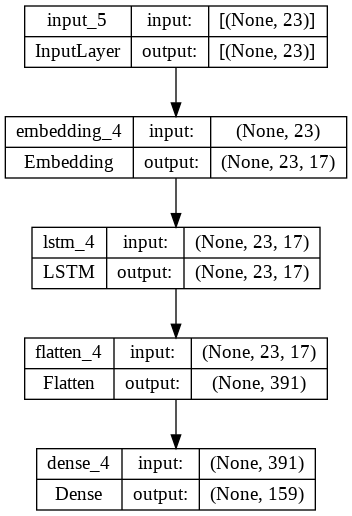

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/content/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Menampilkan Parameter Model
model.summary() 

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 23)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 23, 10)            7060      
                                                                 
 lstm_8 (LSTM)               (None, 23, 16)            1728      
                                                                 
 flatten_8 (Flatten)         (None, 368)               0         
                                                                 
 dense_8 (Dense)             (None, 159)               58671     
                                                                 
Total params: 67,459
Trainable params: 67,459
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
22/22 [==============================] - 2s 5ms/step - loss: 5.0690 - accuracy: 0.0089
Epoch 2/400
22/22 [==============================] - 0s 5ms/step - loss: 5.0449 - accuracy: 0.0163
Epoch 3/400
22/22 [==============================] - 0s 5ms/step - loss: 4.9991 - accuracy: 0.0267
Epoch 4/400
22/22 [==============================] - 0s 5ms/step - loss: 4.9513 - accuracy: 0.0238
Epoch 5/400
22/22 [==============================] - 0s 5ms/step - loss: 4.9332 - accuracy: 0.0238
Epoch 6/400
22/22 [==============================] - 0s 5ms/step - loss: 4.9108 - accuracy: 0.0253
Epoch 7/400
22/22 [==============================] - 0s 5ms/step - loss: 4.8794 - accuracy: 0.0327
Epoch 8/400
22/22 [==============================] - 0s 5ms/step - loss: 4.8361 - accuracy: 0.0357
Epoch 9/400
22/22 [==============================] - 0s 5ms/step - loss: 4.7619 - accuracy: 0.0371
Epoch 10/400
22/22 [==============================] - 0s 6ms/step - loss: 4.6806 - accuracy: 0.0401
Epoch 11/

# **Model Analysis**

Setelah menjalankan pelatihan model dengan algoritma Neural Network dan LSTM serta telah mengetahui hasil akurasi pada step terakhir. Maka, tahapan selanjutnya adalah menganalisa model dengan visualisasi plot akurasi dan loss untuk melihat hasil akurasi dari algoritma pelatihan model Neural Network dengan LSTM tersebut.

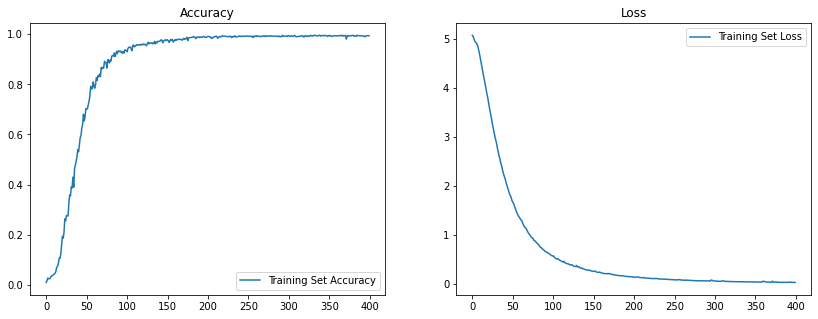

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Terlihat bahwa model pelatihan chatbot dengan algoritma Neural Network + LSTM menghasilkan model yang baik dan tidak terjadi overfitting atau underfitting. Sehingga, model ini layak dilakukan pengujian dan evaluasi model chatbot yang diperoleh.

# **Testing Chatbot Dan Tambahkan Suara Pada Chatbot**

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan algoritma Neural Network dan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya. 

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 KadekBot : ", random.choice(responses[response_tag]))
  #tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
  #tts.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KadekBot.wav')
  time.sleep(0.08)
  # Load model voice bot from Google Drive
  #ipd.display(ipd.Audio('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KadekBot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : halo
1/1 [==============================] - 0s 337ms/step
🤖 KadekBot :  Satu orang yang ada disaat seribu satu orang melupakanmu.



KeyboardInterrupt: ignored

# **Save The Model**

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. Penyimpanan file model bisa langsung secara transient atau bisa taruh di Google Drive.

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('/content/chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!
